In [53]:
from PIL import Image
import shutil
import cv2 as cv
import os
from sklearn.utils import shuffle
import torch , torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader , Dataset
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch import optim
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

plt.ion()

%matplotlib inline

In [54]:
train_df = pd.read_csv('new.csv')

In [55]:
train_df['emotion'].value_counts()

5    200
4    200
3    200
2    200
1    200
0    200
Name: emotion, dtype: int64

In [56]:
classes = ['anger', 'surprise', 'disgust', 'neutral', 'happiness',
       'sadness']

In [57]:
classes_val = {'anger':0, 'surprise':1, 'disgust':2, 'neutral':3, 'happiness':4,
       'sadness':5}

In [58]:
train_df[1:10]

,image,emotion
1,Rollie_Massimino_0001.jpg,5
2,Dwarakish_53.jpg,2
3,Dwarakish_190.jpg,2
4,Mark_Schweiker_0002.jpg,1
5,Barbra_Streisand_0003.jpg,3
6,Iva_Majoli_0001.jpg,5
7,Diana_Silvius_0001.jpg,4
8,Tom_Brennan_0001.jpg,0
9,Mona_Locke_0001.jpg,3


In [59]:
def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [plt.imread(f'images_dataset/{filename}') for filename in filenames]
    
    return plot_images(imgs, labels, rows)
  
def plot_images(imgs, labels, rows=4):
    figure = plt.figure(figsize=(13,8))

    cols = len(imgs) // rows + 1

    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(classes[labels[i]], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')
 

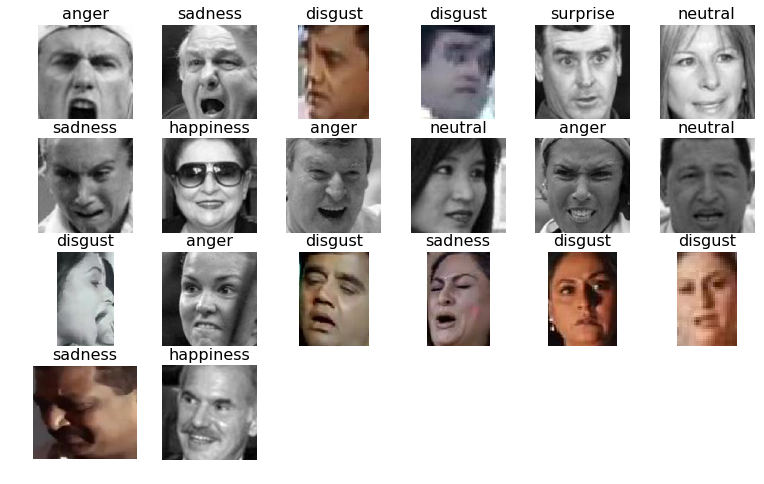

In [60]:
rand_rows = train_df[:20]
imgs = list(rand_rows['image'])
labels = list(rand_rows['emotion'])

plot_images_for_filenames(imgs, labels)




(350, 350)


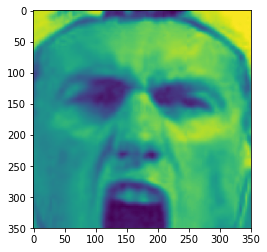

In [61]:
sample_image = plt.imread(f'images_dataset/{imgs[0]}')
print(sample_image.shape)
plt.imshow(sample_image)


In [62]:
print(sample_image.shape)


(350, 350)


In [63]:
t1 = transforms.ToPILImage()
t2 = transforms.ToTensor()
t3 = transforms.Resize([128,128])
t4 = transforms.Grayscale(num_output_channels=1)
t5  = transforms.Normalize(mean=[0.5],std=[0.5])

In [64]:
img = t1(t5(t2(t4(t3(t1(t2(sample_image)))))))

<PIL.Image.Image image mode=L size=128x128 at 0x7F11742EF908>


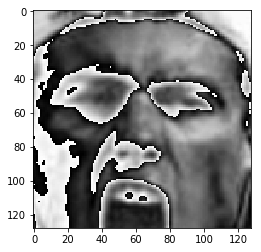

In [65]:
print(img)
plt.imshow(img)



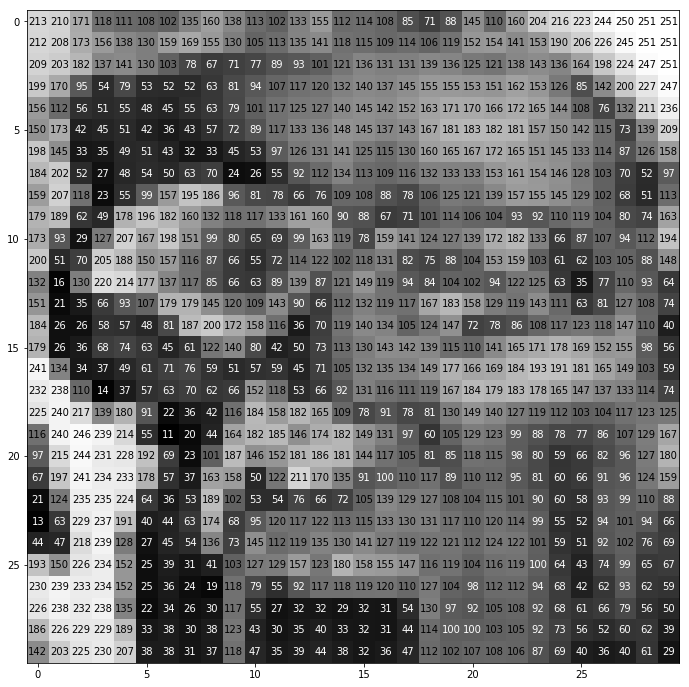

In [66]:
t3 = transforms.Resize([30,30])
img = t3(img)
img = np.squeeze(img)

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [67]:
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.ToPILImage(),
        transforms.Resize([128,128]),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(),                                
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5],std=[0.5]),
#         transforms.ToPILImage()
    ])

In [68]:
class ImageDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
    
  def __len__(self):
    return len(self.frame)
  
  def __getitem__(self, idx):
    img_name = os.path.join(self.root_dir,self.frame.iloc[idx, 0])
    image = Image.open(img_name)
    sample = [ image, self.frame.iloc[idx,1]]
    if self.transform:
      sample[0] = self.transform(sample[0])
    return sample
    

In [69]:
face_dataset = ImageDataset(csv_file='new.csv' , root_dir='images_dataset' , transform = data_transform)
for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample[0].shape, sample[1])
    if i == 10:
        plt.show()
        break

0 torch.Size([1, 128, 128]) 0
1 torch.Size([1, 128, 128]) 5
2 torch.Size([1, 128, 128]) 2
3 torch.Size([1, 128, 128]) 2
4 torch.Size([1, 128, 128]) 1
5 torch.Size([1, 128, 128]) 3
6 torch.Size([1, 128, 128]) 5
7 torch.Size([1, 128, 128]) 4
8 torch.Size([1, 128, 128]) 0
9 torch.Size([1, 128, 128]) 3
10 torch.Size([1, 128, 128]) 0


In [70]:
print(face_dataset[0])


[tensor([[[ 0.9765,  0.9843,  0.9843,  ...,  0.8275,  0.8196,  0.8039],
         [ 0.9686,  0.9843,  0.9843,  ...,  0.8275,  0.8196,  0.8039],
         [ 0.9843,  0.9843,  0.9843,  ...,  0.8353,  0.8275,  0.8118],
         ...,
         [ 0.0353,  0.0510,  0.0588,  ..., -0.1451,  0.0510,  0.1451],
         [ 0.0510,  0.0510,  0.0510,  ..., -0.0980,  0.0667,  0.1451],
         [ 0.0667,  0.0588,  0.0510,  ..., -0.0431,  0.0824,  0.1373]]]), 0]


In [71]:
num_workers = 0
batch_size = 30
valid_size = 0.2
test_size = 0.1
num_train = len(face_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_set = int(np.floor(valid_size * num_train))
test_set  = int(np.floor(test_size * num_train))
test_idx,valid_idx , train_idx = indices[:test_set], indices[test_set:test_set+valid_set] , indices[test_set+valid_set :] 
                                                                                                   



In [72]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)


train_loader = torch.utils.data.DataLoader(face_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(face_dataset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(face_dataset, batch_size=batch_size, 
    num_workers=num_workers)

tensor([1, 4, 5, 3, 3, 3, 4, 4, 1, 0, 4, 0, 4, 3, 4, 0, 3, 0, 5, 1, 4, 3, 4, 3,
        1, 0, 3, 4, 0, 1])
torch.Size([1, 128, 128])


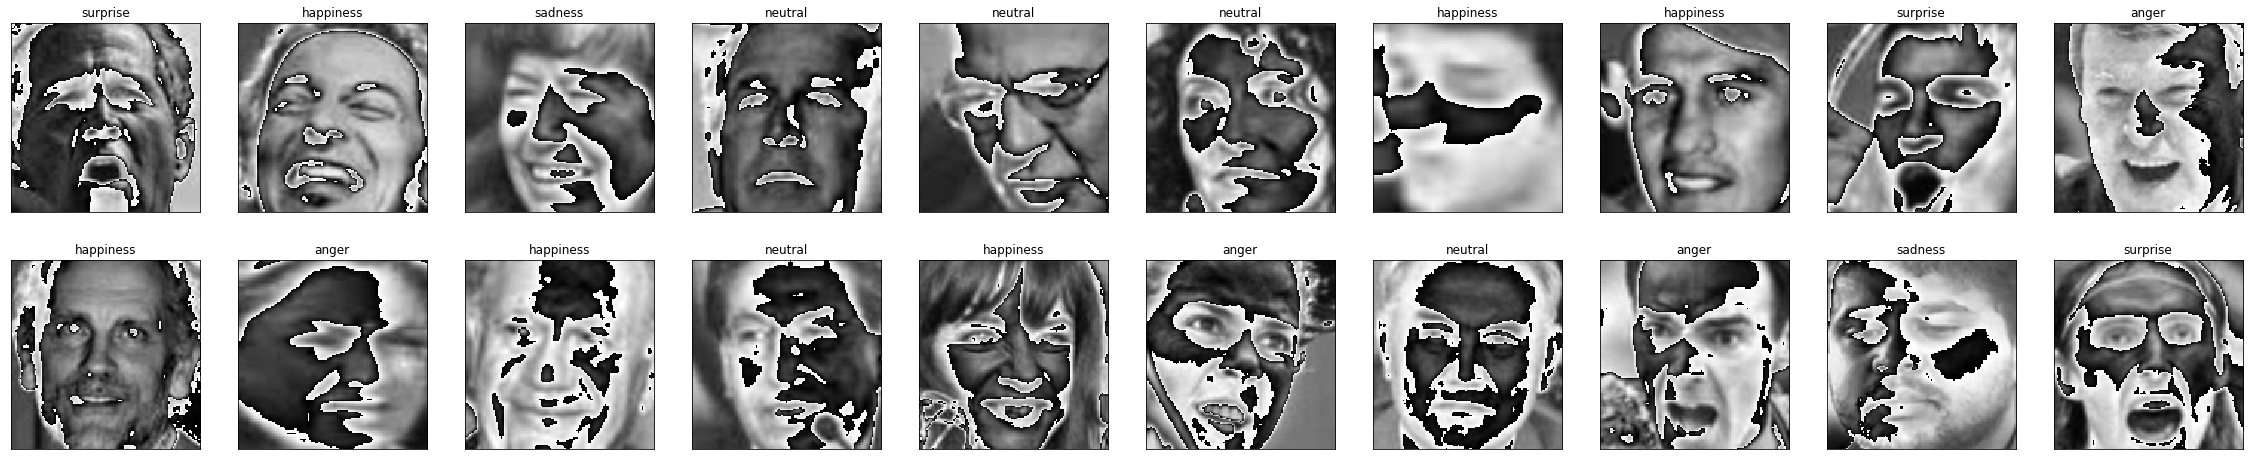

In [73]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
to_pil = torchvision.transforms.ToPILImage()
print(labels)
print(images[5].shape)
fig = plt.figure(figsize=(40, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(to_pil(images[idx]))
    ax.set_title(classes[labels[idx]]) 
  

In [74]:
print(images[1])

tensor([[[-0.7255, -0.7255, -0.7176,  ..., -0.7490, -0.7255, -0.7020],
         [-0.7255, -0.7255, -0.7176,  ..., -0.6784, -0.6471, -0.6235],
         [-0.7333, -0.7255, -0.7176,  ..., -0.6078, -0.5922, -0.5686],
         ...,
         [-0.6157, -0.6392, -0.6549,  ..., -0.8980, -0.8902, -0.8667],
         [-0.6314, -0.6549, -0.6706,  ..., -0.9137, -0.9216, -0.9059],
         [-0.6549, -0.6784, -0.6941,  ..., -0.9216, -0.9373, -0.9294]]])


In [75]:

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [76]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 500)
        self.fc2 = nn.Linear(500, 6)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=6, bias=True)
  (dropout): Dropout(p=0.25)
)


In [77]:
CUDA_LAUNCH_BLOCKING=1

In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [79]:
n_epochs = 50

valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if train_on_gpu:
            data, target = data.cuda() , target.cuda()
            model = model.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        

    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        if train_on_gpu:
            data, target = data.cuda() , target.cuda()
            model = model.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.253981 	Validation Loss: 0.358716
Validation loss decreased (inf --> 0.358716).  Saving model ...
Epoch: 2 	Training Loss: 1.252501 	Validation Loss: 0.358792
Epoch: 3 	Training Loss: 1.251624 	Validation Loss: 0.358707
Validation loss decreased (0.358716 --> 0.358707).  Saving model ...
Epoch: 4 	Training Loss: 1.250550 	Validation Loss: 0.358668
Validation loss decreased (0.358707 --> 0.358668).  Saving model ...
Epoch: 5 	Training Loss: 1.249501 	Validation Loss: 0.358302
Validation loss decreased (0.358668 --> 0.358302).  Saving model ...
Epoch: 6 	Training Loss: 1.247179 	Validation Loss: 0.357742
Validation loss decreased (0.358302 --> 0.357742).  Saving model ...
Epoch: 7 	Training Loss: 1.245798 	Validation Loss: 0.357021
Validation loss decreased (0.357742 --> 0.357021).  Saving model ...
Epoch: 8 	Training Loss: 1.242210 	Validation Loss: 0.355902
Validation loss decreased (0.357021 --> 0.355902).  Saving model ...
Epoch: 9 	Training Loss: 1.238644 

In [80]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([16, 1, 3, 3])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 3, 3])
conv2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([64, 32, 3, 3])
conv3.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([500, 16384])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([6, 500])
fc2.bias 	 torch.Size([6])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [139712954822872, 139712954825680, 139712954825320, 139712954826256, 139712954825896, 139712954826040, 139712954826184, 139712954826400, 139712954825608, 139712954826688]}]


In [81]:
torch.save(model.state_dict(), "parameters.pt")